In [4]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

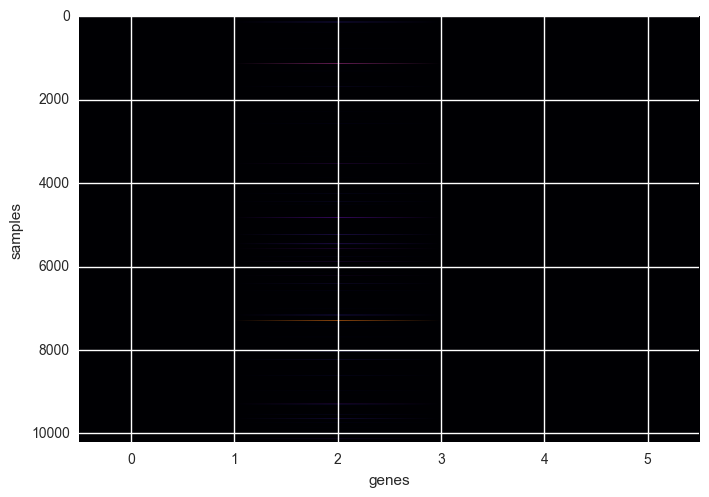

In [13]:
exome = pd.read_excel("HC3_js_exomes_2_MG_170307.xlsx")
exomeFiltered = exome.loc[:, ['GERP','CADD_score', 'Dist2Splice','AB', 'P1_AltFreq', 'P2_AltFreq' ,'localization', 'js_cause']]
exomeLoc = exomeFiltered.loc[:,['GERP','CADD_score', 'Dist2Splice','AB', 'P1_AltFreq', 'P2_AltFreq' , 'localization']]
exomeJS = exomeFiltered.loc[:,['GERP','CADD_score', 'Dist2Splice','AB', 'P1_AltFreq', 'P2_AltFreq' , 'js_cause']]
exomeTest = exomeFiltered.loc[:,['GERP','CADD_score', 'Dist2Splice','AB', 'P1_AltFreq', 'P2_AltFreq' ]]

genes = exomeTest.values
cancer_types = exomeLoc['localization'].values

h = plt.imshow(genes, aspect='auto')
h.set_cmap('inferno')
plt.xlabel('genes')
plt.ylabel('samples')

In [14]:
from sklearn.decomposition import PCA

genes_pca = PCA()
genes_pc = genes_pca.fit_transform(genes)

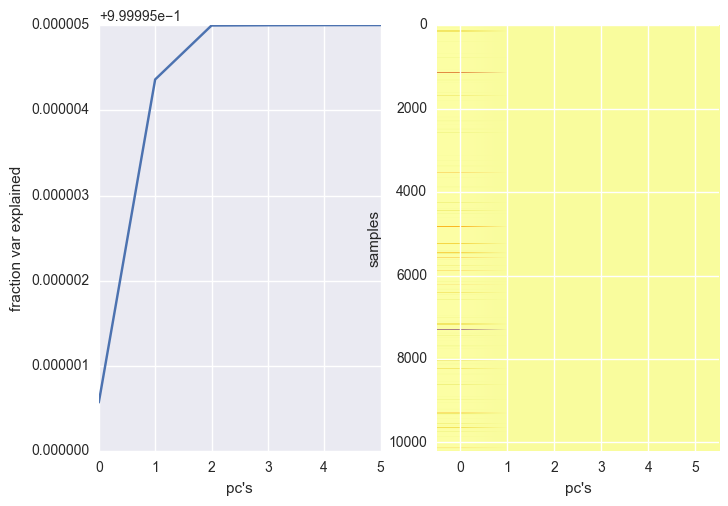

In [15]:
fg = plt.figure()

fg.add_subplot(1,2,1)
plt.plot(np.cumsum(genes_pca.explained_variance_ratio_))
plt.xlabel("pc's")
plt.ylabel('fraction var explained')

fg.add_subplot(1,2,2)
h = plt.imshow(genes_pc[:, :40], aspect='auto')
h.set_cmap('inferno')
plt.xlabel("pc's")
plt.ylabel('samples')

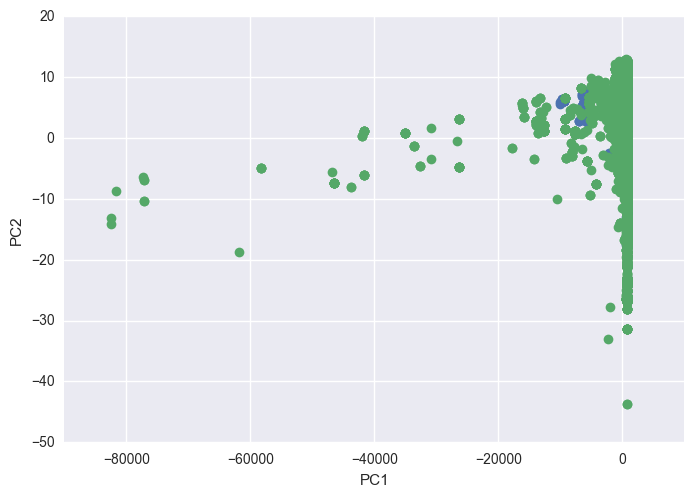

In [16]:


for c in np.unique(cancer_types):
    plt.plot(genes_pc[cancer_types==c,0], 
             genes_pc[cancer_types==c,1], 'o')
    
plt.xlabel('PC1')    
plt.ylabel('PC2')

In [17]:
def test_train_id(N, test_frac):
    ntrain = np.floor(N * (1 - test_frac)).astype(int)
    randperm = np.random.permutation(N)
    train = randperm[:ntrain]
    test = randperm[(ntrain-N):]
    return train, test

In [18]:
from sklearn.decomposition import PCA

def cross_val_class_accuracy(model, X, y, r, test_frac, reps):
    genes_pca = PCA()
    
    score = np.array([])
    for i in range(reps):
        train, test = test_train_id(y.size, test_frac)
        y_train = y[train]
        y_test = y[test]
        
        X_train = genes_pca.fit_transform(X[train, :])[:, :r]
        X_test = genes_pca.transform(X[test, :])[:, :r]
        
        model.fit(X_train, y_train)
        
        pred = model.predict(X_test)
        this_score = sum(pred == y_test) / len(y_test)
        
        score = np.append(score, this_score)
    return score

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


score = cross_val_class_accuracy(LinearDiscriminantAnalysis(), genes, 
                                cancer_types, 5, 0.2, 200)
print(score.mean())

0.980587371512


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

testfrac = 0.2
reps = 200

lda_r5_scores = cross_val_class_accuracy(LinearDiscriminantAnalysis(), 
                                          genes, cancer_types, 5,
                                          testfrac, reps)
lda_r20_scores = cross_val_class_accuracy(LinearDiscriminantAnalysis(), 
                                          genes, cancer_types, 20,
                                          testfrac, reps)
knn2_scores = cross_val_class_accuracy(KNeighborsClassifier(n_neighbors=2),
                                       genes, cancer_types, 20,
                                       testfrac, reps)
knn10_scores = cross_val_class_accuracy(KNeighborsClassifier(n_neighbors=10),
                                       genes, cancer_types, 20,
                                        testfrac, reps)
svm_scores = cross_val_class_accuracy(svm.SVC(kernel='linear'),
                                      genes, cancer_types, 20, 
                                      testfrac, reps)
tree_scores = cross_val_class_accuracy(DecisionTreeClassifier(max_depth=3),
                                       genes, cancer_types, 20,
                                       testfrac, reps)

In [ ]:
classifiers = ('lda_r5', 'lda_r20', 'knn2', 'knn10', 'svm', 'tree')
scores = [lda_r5_scores.mean(), lda_r20_scores.mean(), 
          knn2_scores.mean(), knn10_scores.mean(),
         svm_scores.mean(), tree_scores.mean()]
scores_err = [lda_r5_scores.std(), lda_r20_scores.std(), 
          knn2_scores.std(), knn10_scores.std(),
         svm_scores.std(), tree_scores.std()]


plt.bar(range(len(classifiers)), scores, 
        yerr=scores_err,
        align='center', alpha=0.4,)
plt.xticks(range(len(classifiers)), classifiers)
plt.ylabel('Cross-validated accuracy')
plt.xlabel('Classification Algorithm')